
# Generador de textos "La Biblia"
### Erick Fernando López Fimbres.  
#### erick.lopez.fimbres@gmail.com

## Definición

Para la realizacion de esta libreta fue elaborado a partir de esta otra [libreta](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb) la cual se encuentra en el idioma ingles, utilizaremos las bases para nuestro proyecto haciendo algunas modificaciónes con nuestro dataset de [municipios de México](datos/BIBLIA_COMPLETA.txt).
Nuestro proposito es generar parrafos los cuales se generan caracter por caracter a partir deldocumento de la biblia utilizando el framework de redes profundas **PyTorch**.




## Preparación de datos 

Si no tienes instalada la libreria unidecode ingresa el siguiente comando en Linux
```
conda install -c anaconda unidecode
```

In [6]:
import unidecode
import string
import random
import re

#para la clase RNN
import torch
import torch.nn as nn
from torch.autograd import Variable

#Para medir tiempos de ejecucion y calculos 
import time, math

todos_caracteres = string.printable
n_caracteres = len(todos_caracteres)

archivo = unidecode.unidecode(open('datos/BIBLIA_COMPLETA.txt',encoding="ISO-8859-1").read())
tam_archivo = len(archivo)
print('Tamaño del archivo en caracteres: ', tam_archivo)

Tamaño del archivo en caracteres:  4041437


Ahora fragmentaremos el texto

In [14]:
longitud_fragmento = 1000

def fragmento_aleatorio():
    i_ini = random.randint(0, tam_archivo - longitud_fragmento)
    i_final = i_ini + longitud_fragmento + 1
    return archivo[i_ini:i_final]

print(fragmento_aleatorio())

No obran mas bien ellos mismos su propia confusion? 20 Por tanto, asi ha dicho Jehova el Senor: He aqui que mi furor y mi ira se derramaran sobre este lugar, sobre los hombres, sobre los animales, sobre los arboles del campo y sobre los frutos de la tierra; se encenderan, y no se apagaran. 

Castigo de la rebelion de Juda

21 Asi ha dicho Jehova de los ejercitos, Dios de Israel: Anadid vuestros holocaustos sobre vuestros sacrificios, y comed la carne. 22 Porque no hable yo con vuestros padres, ni nada les mande acerca de holocaustos y de victimas el dia que los saque de la tierra de Egipto. 23 Mas esto les mande, diciendo: Escuchad mi voz, y sere a vosotros por Dios, y vosotros me sereis por pueblo; y andad en todo camino que os mande, para que os vaya bien. 24 Y no oyeron ni inclinaron su oido; antes caminaron en sus propios consejos, en la dureza de su corazon malvado, y fueron hacia atras y no hacia adelante, 25 desde el dia que vuestros padres salieron de la tierra de Egipto hasta 

## Construyendo el modelo

In [15]:
class RNN(nn.Module):
    def __init__(self, tam_entrada, tam_oculto, tam_salida, num_capas=1):
        super(RNN, self).__init__()
        self.tam_entrada = tam_entrada
        self.tam_oculto = tam_oculto
        self.tam_salida = tam_salida
        self.num_capas = num_capas
        
        self.encoder = nn.Embedding(tam_entrada, tam_oculto)
        self.gru = nn.GRU(tam_oculto, tam_oculto, num_capas)
        self.decoder = nn.Linear(tam_oculto, tam_salida)
    
    def forward(self, entrada, oculta):
        entrada = self.encoder(entrada.view(1, -1))
        salida, oculta = self.gru(entrada.view(1, 1, -1), oculta)
        salida = self.decoder(salida.view(1, -1))
        return salida, oculta

    def init_hidden(self):
        return Variable(torch.zeros(self.num_capas, 1, self.tam_oculto))

## Entradas y objetivos

In [16]:
# Convierta la cadena en una lista larga
def caracter_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = todos_caracteres.index(string[c])
    return Variable(tensor)

print(caracter_tensor('abcDEF'))

Variable containing:
 10
 11
 12
 39
 40
 41
[torch.LongTensor of size 6]



In [17]:
def conjunto_entrenamiento_aleatorio():    
    pedazo = fragmento_aleatorio()
    entrada = caracter_tensor(pedazo[:-1])
    objetivo = caracter_tensor(pedazo[1:])
    return entrada, objetivo

## Evaluando

Para evaluar la red la alimentaremos con un carácter a la vez, usaremos los resultados de la red como una distribución de probabilidad para el siguiente carácter y repetiremos este proceso.

In [18]:
def evaluar(prime_str='A', predict_len=100, temperature=0.8):
    oculta = decoder.init_hidden()
    entrada_principal = caracter_tensor(prime_str)
    prediccion = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, oculta = decoder(entrada_principal[p], oculta)
    entrada = entrada_principal[-1]
    
    for p in range(predict_len):
        salida, oculta = decoder(entrada, oculta)
        
        # Muestra de la red como una distribución multinomial
        distribucion_salida = salida.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(distribucion_salida, 1)[0]
        
        # Add predicted character to string and use as next input
        caracter_predicho = todos_caracteres[top_i]
        prediccion += caracter_predicho
        entrada = caracter_tensor(caracter_predicho)

    return prediccion

## Entrenamiento

In [19]:
def tiempo(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
def entrenamiento(entrada, objetivo):
    oculta = decoder.init_hidden()
    decoder.zero_grad()
    perdida = 0

    for c in range(longitud_fragmento):
        salida, oculta = decoder(entrada[c], oculta)
        perdida += criterion(salida, objetivo[c])

    perdida.backward()
    decoder_optimizer.step()

    return perdida.data[0] / longitud_fragmento

Definimos los parámetros de entrenamiento, instanciamos el modelo y comenzamos a entrenar:

In [23]:
max_epoch = 2000 #numero de epoch para el entrenamiento
impresion = 100
graficar = 10
tam_oculto = 100
num_capas = 2
epsilon = 0.005

decoder = RNN(n_caracteres, tam_oculto, n_caracteres, num_capas)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=epsilon)
criterion = nn.CrossEntropyLoss()

comienzo = time.time()
historial_perdidas = []
prmedio_perdida = 0

for epoch in range(1, max_epoch + 1):
    perdida = entrenamiento(*conjunto_entrenamiento_aleatorio())       
    prmedio_perdida += perdida

    if epoch % impresion == 0:
        print('[%s (%d %d%%) %.4f]' % (tiempo(comienzo), epoch, epoch / max_epoch * 100, perdida))
        print(evaluar('J', 100), '\n')

    if epoch % graficar == 0:
        historial_perdidas.append(prmedio_perdida / graficar)
        prmedio_perdida = 0

 38s (100 5%) 2.1127]
Jies Cues benterado tecara su de veraz al aite a sante puebcontante tocftamlacara estala reamran-ra p 

 56s (200 10%) 1.8003]
Jcrijo de la de entrosta los he allalas contando carme; y manciado de Isran cervis acortie la ya ni l 

 25s (300 15%) 1.6622]
Jj"hado su agertonos; teimo se que guan estaledios en le gintidias, y los parenigo en la tierran mas  

 43s (400 20%) 1.7614]
J-fijo a tay se jodia en ti aldelarita ella de mi las para soy sierto, que ha cierran en a la corviri 

 43s (500 25%) 1.5602]
J|ban de Poraquio hambien a la contalen de efero del haces los he Israel. Y este de Galam, diciendo l 

 21s (600 30%) 1.5627]
JMi|d, y candas de Jospues sina grande conias, y que habia Dios. 8 Y tanto mas senerasetes dor; Jehov 

 3s (700 35%) 1.6306]
J!ACON-PRZM>; Oy huyo camino la juda de Jehova de laba a Josuhos de los hombras contra que sus mieros 

 4s (800 40%) 1.3647]
Jododes, yo los hermano de los ida la sallaran de bed tu camas, todos los osrezando en con 

## Graficación de los errores

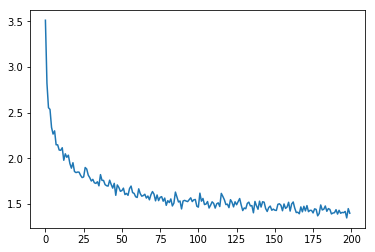

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(historial_perdidas)

## Resultados con diferentes temperaturas 

En la función de evaluación anterior, cada vez que se realiza una predicción, las salidas se dividen por el argumento "temperatura" pasado. Usar un número más alto hace que todas las acciones sean más equitativas y, por lo tanto, nos brinda salidas "más aleatorias".

Usar un valor más bajo (menos de 1) hace que las probabilidades altas contribuyan más. A medida que aumentamos la temperatura hacia cero, estamos eligiendo solo las salidas más probables.

In [65]:
print(evaluar('Dios v', 1000, temperature=0.8))

Dios volvio por lleguidor votos te has compasion a ellos, del efeladro y que envian para fueron; y no con las sangres de la piedra a Cristo. 

La efel, consutalo nado testigo, y de la tierra lo que habitaraamente boce a los hijos y hijo mil medio que ha que se lanta con estas tambien el called de ella por sus sitomos. 8 De los ha se dijo: Jehova: De ellos mientes bebera en cacho han estovo de la tierra de Sion, para quedara Juda, nados habia habia hermano, sino que el anigar en vuestro Dios, al tiempo en el sabeis, y a para que te tambien a ti dara envio que la tierra temor, y al tendra, y cuales te entre los ganozoras y su padre. 3 Y al ribaria y ser vendra que este bien, sino que el Dios, al malor a Ahora de sus hijos de los reyes, y de abrio y los libanzas, y las lados, en todas las entres de verdotes, ni fuego traereis sera todas las libando al ganado. 5 No te diciendo la tierra a el Senor, el que estan traidonia de ellos a mi hiervo, y con el tomado a la castad que para el camino 

In [34]:
print(evaluar('Israel', 1000, temperature=0.2))

Israel de los levitas de la tierra de la tierra de los hijos de los hijos de los hijos de los que habia hecho a la tierra de los que el padre a los hijos de la tierra de los hijos de los hijos de los hijos de la tierra de la tierra de la tierra de la tierra, y la tierra de los hijos de la tierra de la tierra de la tierra de la tierra de los que el angeles de la tierra de la tierra de la tierra de la tierra de los hijos de los hijos de los hijos de la tierra de los hijos de la tierra de la tierra de la tierra de ellos. 

2 Y la tierra de la tierra de los que habia hijo de los hijos de los hijos de los hijos de los hijos de los padres, y la tierra de la tierra de la tierra de los hijos de la tierra de la tierra de los que habia habia habia hijo de la tierra de la tierra de los hijos de la tierra de los que habia conforme de los hijos de la tierra de la tierra de los hijos de los hijos de los que habia hecho a los hijos de los hijos de los hijos de los que habia para la tierra de los hijo

In [49]:
print(evaluar('Jehova', 1000, temperature=.5))

Jehova a tu padre. 

2 Esta para que habia enfermos de los hijos de Catras, y la grande son salido en ellos de los hijos de Ahora, y la tierra que habia hijo de los hijos de Cada habia trabanas partes, y te aqui el entranieron que se habia habia le sino que habia con mano de los hijos de la profeta, y con tambien la tierra de tomaron con muerte sola para que hablado con todo lo sepultado anos de los que acerca y a la tierra de aqui la casa de Zabaras que estaba para solio en todos los que el perdones de la nacion con todos los entrescion de las angalos; y de los encenderan no trabajo trabocaste a ellos al trair de los habia pan de la saldad de ello; y su que te habia de camino de sus reyes que el hombre a la tierra en rey habia hecho a tu padre. 

El dijo a sus hermanos, y tambien no habia hijo de Asa el partigo, de la tambien en Aseras, y se ha de la salid a los hijos de los que habia habia padre. 

Los que habian en la bada por mi mensan sus siervos traberas de Jehova a Mananias, y A